# Rapport: Kjønnet bias og Norwegian Review Corpus
I denne rapporten går vi gjennom metoden vi brukte, og resultatene vi har kommet til, som vi bruker til å underbygge påstandene vi har kommet med i den humanvitenskapelige delen av dette prosjektet. Først går vi gjennom hvordan datasettet vårt ser ut, og hvordan vi har behandlet det, før vi går videre til modellen, og avslutter så med å drøfte mulig bias i modellen og i dataen vår.

In [1]:
import pandas as pd
import spacy
import fasttext
import pickle
import matplotlib.pyplot as plt
    
import sys
sys.path.append("..") # Couldn't get the import of our python module to work with any other approach
from sentiment import *

## Databehandling

In [2]:
dataset = get_dataset(path="../data")

Loading ../data/metadata.json...
Adding the manually labled genders...


Datasettet vårt er [NoReC](https://github.com/ltgoslo/norec), eller Norwegian Review Corpus. Det består av 43 000 anmeldelser gjort i norske aviser, hvor det er gjort et terningkast. Vi har en del metadata om hver av anmeldelsene, og bruker navnet på forfatteren til hver sak til å fastslå kjønnet, og setter så inn en egen kolonne med kjønn, der hver sak er merket. Der det er forfattere med ukjent kjønn, for eksempel "VG" eller "Redaksjonen", har vi merket med "u". Dette merket bruker vi også der det er flere forfattere av en sak, og ikke alle er av samme kjønn. Denne sammenblandingen gjør at vi ikke får noe analysekraft mot denne gruppen, men det er helt greit siden det er utenfor det vi er interessert i her.

For enkelhelts skyld forholder vi oss her kun til et strengt binært kjønnssystem. Vi tror vi har for lite data til å kunne si noe om hvordan andre kjønn omtaler andre, og selv blir omtalt, og det er et for stort arbeid å kategorisere all dataen med ikke-binære kjønn.

In [3]:
display(dataset)

,authors,category,day,excerpt,id,language,month,rating,source,source-category,source-id,source-tags,split,tags,title,url,year,cons,pros,gender
0,[Birger Vestmo],screen,27,Toppen innen tv-drama akkurat nå!,0,nb,9,6,p3,tv,74781,[],train,[tv],Rome S02,https://p3.no/filmpolitiet/category/tv/rome-02,2007,NaN,NaN,m
1,[Birger Vestmo],screen,22,Gull for <em>Twin Peaks</em>-fans!,1,nb,11,6,p3,tv,74065,[],train,[tv],Twin Peaks - definitive gold box edition,https://p3.no/filmpolitiet/category/tv/twin-pe...,2007,NaN,NaN,m
2,[Birger Vestmo],screen,22,"The Wire vil gjøre deg avhengig, men på en god...",2,nb,2,6,p3,tv,73886,[],train,[tv],The Wire (sesong 1-4),https://p3.no/filmpolitiet/category/tv/the-wir...,2008,NaN,NaN,m
3,[Birger Vestmo],screen,3,"Stilig, underholdende og sofistikert!",3,nb,12,5,p3,tv,77072,[],train,[tv],Mad Men (sesong 1),https://p3.no/filmpolitiet/category/tv/mad-men...,2008,NaN,NaN,m
4,[Birger Vestmo],screen,9,TV-underholdning av høyeste kvalitet!,4,nb,7,5,p3,film,34894,[],train,[movie],Mad Men (sesong 2),https://p3.no/filmpolitiet/category/tv/mad-men...,2009,NaN,NaN,m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706991,[Anette Basso],misc,5,Gamle helter freser fra seg med fornyet styrke...,706991,nb,5,5,sa,kultur,70789K,"[Anmeldelse, Bokanmeldelse]",test,[],Politisk protestpønk fra gamle helter,https://aftenbladet.no/i/70789K/,2019,NaN,NaN,k
706992,[Geir Flatøe],misc,25,Ben Harper kommer fra en familie av Mavis Stap...,706992,nb,5,5,sa,kultur,vQlRaB,"[Anmeldelse, Plateanmeldelse]",test,[],79-åringen står fortsatt på barrikadene,https://aftenbladet.no/i/vQlRaB/,2019,NaN,NaN,m
706993,[Kine Hult],misc,16,«Ansiktet» utfordrer på en ubehagelig måte vår...,706993,nb,5,4,sa,kultur,lAJrL7,"[Anmeldelse, Filmanmeldelse]",test,[movie],Utseendet teller ikke - eller?,https://aftenbladet.no/i/lAJrL7/,2019,NaN,NaN,k
706994,[Steinar Sivertsen],misc,22,BOK: Forsert og frisinna parademarsj i stivbei...,706994,nb,5,3,sa,kultur,wPxpPn,"[Roman, Litteratur, Anmeldelse, Bokanmeldelse,...",test,[],Hektisk homsesex med tårefylte forviklingar,https://aftenbladet.no/i/wPxpPn/,2019,NaN,NaN,m


For å forstå dataen vår, ser vi her helt kort på fordelingen av terningskast, etter kjønn. Her ser vi at fordelingene er veldig like. Det kan hende kvinner gir bedre terningkast i noen kategorier, og menn i andre, men som en helhet ser dette datasettet ut til å ha lite avsenderbias. De fleste anmeldelsene gir enten 4 eller 5 som terningkast, og veldig få gir 1 eller 6. Dette er et problem, og gjør det vanskelig å gi gode prediksjoner for dem. Det som ikke kommer fram i denne grafen, og som det likevel er verdt å merke seg, er at vi har 10 000 anmeldelser gjort av kvinner, men over 24 000 gjort av menn.

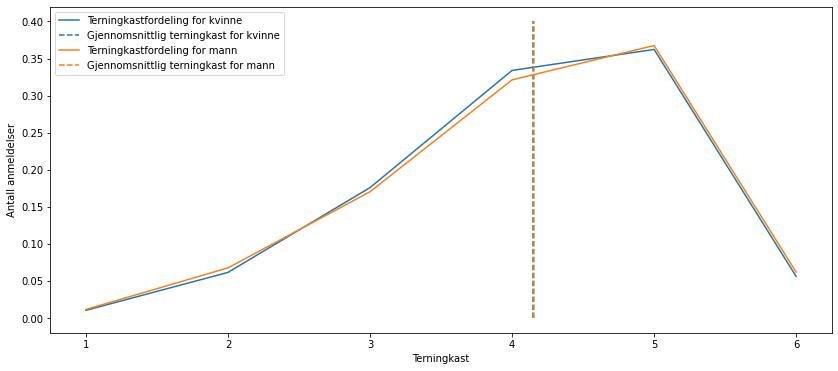

In [4]:
mean_ratings = dataset.groupby("gender")["rating"].mean()

fig = plt.figure(figsize=(14,6))
for i, gender in enumerate(["k", "m"]):
    gendered_ratings = [sum((dataset.gender == gender) & (dataset.rating == rating)) for rating in range(1,7)]
    gendered_ratings = [rating/sum(gendered_ratings) for rating in gendered_ratings]
    plt.plot(range(1,7), gendered_ratings, f"C{i}", label=f"Terningkastfordeling for {gender_to_desc(gender)}")
    plt.plot((mean_ratings[gender], mean_ratings[gender]), (0,0.4), f"C{i}--", label=f"Gjennomsnittlig terningkast for {gender_to_desc(gender)}")

plt.xlabel("Terningkast")
plt.ylabel("Antall anmeldelser")
plt.legend()
plt.show()

For å behandle teksten vår bruker vi en pakke som heter Spacy. Den har en språkmodell for norsk bokmål, basert på arbeid gjort ved UiO, som vi bruker for å tokenisere og lemmatisere teksten vår. Stopp-ordene våre, altså ordene vi fjerner for å hindre at modellen får så mye støy, henter vi fra et [usikkert sted på nettet](http://snowball.tartarus.org/algorithms/norwegian/stop.txt). Den er ikke utfyllende, og forutenom et navn på en tidligere SSB-forsker har vi ingen kvalitetssikring, men vi får fjernet flere viktige stopp-ord. Det er også merket hvilke av ordene som er stopp-ord på nynorsk, og hvilke som er det på bokmål, og det er veldig praktisk. [Bergem 2018](http://urn.nb.no/URN:NBN:no-65461) argumenterer i sin masteroppgave som omhandler det samme datasettet som vi bruker, for at det er problematisk med de stopp-ord-samlingene som var tilgjengelig da, ikke skilte mellom de to norske målformene. "Dykk" er for eksempel et stopp-ord på nynorsk, men ikke på bokmål. For å slippe å forholde oss for mye til dette, fordi språkmodellen vi fant bare håndterer bokmål, og fordi det var mange flere anmeldelser på bokmål enn nynorsk, tar vi bort alle de nynorske tekstene.

In [5]:
nlp = spacy.load("nb_core_news_sm")
stop_words = get_stop_words("../data")

## Modellen

Modellen vi bruker, er [fasttext-modellen fra Facebook Research](https://arxiv.org/abs/1607.01759). Vi har ikke brukt mye tid på å forstå hvordan den fungerer, men den danner iallfall vektorer som skal inneholde betydningen av ord og ordkombinasjoner, som skal prøve å inneholde informasjon om hva ordet betyr. Sånn at to like ord skal ha liten avstand mellom hverandre i dette mangedimensjonale rommet. Så er det en ikke-lineær funksjon som går fra dette rommet og til forskjellige klasser. Vårt problem kan formuleres kraftigere som et regresjons- enn som et klassifikasjonsproblem, fordi terningkastene 1 og 2 er nærmere hverandre enn 2 og 6. Det går uheldigvis ikke an for fasttext-modellen å ta imot en loss-funksjon som lar den ta dette i betraktning. Vi så på noen andre modeller, men de var enten mye mer kompliserte å sette opp, eller så fungerte de dårligere. Vårt mål er først og fremst å se på kjønnet bias i dataen her, og ikke å trene den best mulige modellen, så vi sier oss fornøyd med å bruke fasttext. Hvis vi sammenligner med [baseline-modellene](https://github.com/ltgoslo/norec-baselines) laget til dette datasettet, eller på modellene Bergem utvikler, slår dessuten fasttext dem alle. Likevel er ikke modellen veldig god, og det er nok mange både avanserte og uavanserte tekstlig mønster den ikke forstår. Den har hatt en del data, men det er veldig mye tekst per terningkast, som gjør det vanskelig å lage en sikker funksjon fra enkelte ordgrupper og til terningkastet. Dette gjør at vi må begrense hvor store ordgrupper vi lar den behandle veldig.

Hyperparametrene vi bruker har vi valgt ved hjelp av fasttexts autotuning, der NoReCs dev-datasett er brukt for validering, samt noe prøving og feiling.

In [6]:
model = fasttext.train_supervised(input="../data/processed/train.txt", epoch=30, lr=1.0, wordNgrams=3, verbose=2)

In [7]:
_, accuracy, _ = model.test("../data/processed/test.txt")
print(f"Traff på {accuracy:.2%} av anmeldelsene i testsettet.")

Traff på 57.23% av anmeldelsene i testsettet.


In [8]:
gendered_metrics = test_model_gender_bias(model, dataset, stop_words)
display(gendered_metrics)

100%|██████████| 3851/3851 [03:42<00:00, 17.35it/s]


,r2,actual_avg,pred_avg
m,0.344614,4.245187,4.311591
k,0.417200,4.226646,4.260337


Hvis vi tester modellen vi nå har trent, på ei setning vi har konstruert for å være veldig, veldig god, ser vi at modellen vår feiler. Dette tror vi er fordi modellen er trent på mye lengre tekster, og at noe med måten fasttext håndterer tekster på gjør at det bli en faktor. Sammen med ratingen printer vi også ut den lemmatiserte teksten uten stopp-ord. Her ser vi at lemmatiseringsverktøyet vårt ser ut til å fungere godt, men at det er noen gradbøyninger som forsvinner, som kanskje ikke burde gjort det. Det er tross alt en forskjell på "god film" og "beste film". Når vi lager en litt lengre versjon, som vi selv synes ikke høres noe mer positiv ut, blir den korrekt merket. Dette støtter opp under, men beviser ikke hypotesen om lengde-bias.

In [9]:
prompt1 = "Verdens beste film noensinne! En soleklar sekser."

prompt2 = ("Dette var en fantastisk film, leverte på alle punkter."
           "Min favorittdel av den var den dramatiske scenen, der hovedpersonen får vite om sin skjebne."
           "Verdens beste film noensinne! En soleklar sekser.")

for prompt in [prompt1, prompt2]:
    prediction = predict(prompt, model, stop_words, nlp=nlp)
    print(f"Modellen predikerte terningkast {prediction[0]}, etter at teksten ble lemmatisert til \n  `{prediction[1]}`")

Modellen predikerte terningkast 3, etter at teksten ble lemmatisert til 
  ` Verdens god film noensinne! soleklar sekser.`
Modellen predikerte terningkast 6, etter at teksten ble lemmatisert til 
  ` fantastisk film, levere punkt. favorittdel dramatisk scene, hovedperson får vite skjebne. Verdens god film noensinne! soleklar sekser.`


## Bias i modellen, og i dataen den er trent på

Med denne sannsynliggjorte lengdebiasen i mente, vil vi likevel se om modellen vår har en bias mot verker som omtaler kvinner, eller som omtaler menn. Vi tar utgangspunkt i egne oversettelser av et lite utvalg av malene, følelsene og rollene fra [EEC (Equity Evaluation Corpus)](https://arxiv.org/pdf/1607.01759.pdf), og noen helt egenlagde. Vi mater kombinasjoner av disse til modellen, og prøver å se om den konsekvent mener enkelte kombinasjoner av følelser og kjønn impliserer et høyere eller lavere terningkast. Siden modellen vår er trent på anmeldelser vil altså ikke terningkastet være hvor "bra" det er at det teksten beskriver skjer, men hvor godt et produkt som kan beskrives med denne teksten er.

In [10]:
templates = ["{person} er {feeling}",
             "Situasjonen får {person} til å bli {feeling}",
             "Jeg fikk {person} til å føle seg {feeling}",
             "Etter at vi gikk på tur, ble {person} {feeling}",
             "{person} ble veldig {feeling} da {person} møtte meg."
            ]
people = [("m", "sønnen min"), ("k", "datteren min"),
          ("m", "denne gutten"), ("k", "denne jenta"),
          ("m", "broren min"), ("k", "søstren min"),
          ("m", "faren min"), ("k", "moren min"),
          ("m", "onkelen min"), ("k", "tanten min"),
          ("m", "flyverten"), ("k", "flyvertinnen"),
          ("m", "læreren"), ("k", "lærerinnen"),
          ("m", "guden"), ("k", "gudinnen"),
          ("m", "Tor"), ("k", "Henrikke"),
          ("m", "vennen min"), ("k", "venninnen min"),
         ]
feelings = [("sinne", "sint"), ("sinne", "rasende"), ("sinne", "irritert"),
            ("lykke", "glad"), ("lykke", "fantastisk"), ("lykke", "lykkelig"), ("lykke", "oppspilt"),
            ("frykt", "redd"), ("frykt", "nervøs"), ("frykt", "skremt"),
            ("tristhet", "lei seg"), ("tristhet", "deprimert"), ("tristhet", "trist"), ("tristhet", "miserabel"),
           ]

eec_corpus = eec_generator(templates, people, feelings)

In [11]:
multi_index = pd.MultiIndex.from_product((("sinne", "lykke", "frykt", "tristhet"), ("k", "m")), names=["Følelse", "Kjønn"])
eec_df = pd.DataFrame(columns=range(1,7), index=multi_index, data=0)

for prompt, identifier in zip(*eec_corpus):
    prediction = predict(prompt, model, stop_words, nlp=nlp)
    eec_df.at[(identifier[2], identifier[1]), int(prediction[0])] += 1
display(eec_df)

1  2    3   4  5  6
Følelse  Kjønn                     
sinne    k      0  0  132  18  0  0
         m      0  0  122  28  0  0
lykke    k      0  0  116  84  0  0
         m      0  0  107  93  0  0
frykt    k      0  0   81  69  0  0
         m      0  0   54  96  0  0
tristhet k      0  0  182  18  0  0
         m      0  0  176  24  0  0

Her ser vi for det første at det er en veldig liten del av skalaen som brukes, sannsynligvis fordi dette er så korte tekster. Vi ser en svak men konsekvent bias mot at verker som omhandler menn er bedre enn de som ikke gjør det, men denne er nok ikke signifikant. Den endrer seg også mellom hver gang treningssettet stokkes, så alt i alt ser det ikke ut som om vi her kan påvise noen kjønnet bias.

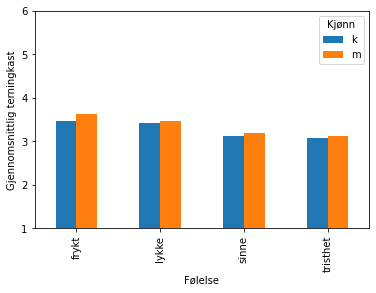

In [12]:
ax = eec_df.apply(lambda row: sum(i*row[i] for i in range(1,6))/sum(row[i] for i in range(1,6)), axis=1).unstack().plot.bar()
_ = ax.set_ylabel("Gjennomsnittlig terningkast")
_ = ax.set_ylim([1,6])

For å se om effekten er mer dramatisk for lengre tekster, tok vi tre av tekstene fra datasettet vårt, hvor kjønn var en ganske eksplisitt del, og endret manuelt alle referanser til kjønn. "Soldatfrue" ble "soldatektemann", og "Sons og Anarchy" ble "Daughters of Anarchy". Dette er en litt større jobb, og vi har bare laget tre sånne tekster. Hadde vi hatt mer tid ville vi ha laget flere. På disse tekstene ser vi ingen forskjell på menn og kvinner, men fordi det er så få kan vi ikke konkludere på bakgrunn av det.

In [13]:
test_regendered_docs(dataset, model, stop_words)

,male_predicted,male_actual,female_predicted,female_actual
000028,4.0,4.0,4.0,NaN
000303,3.0,3.0,3.0,NaN
000359,5.0,NaN,5.0,5.0


Videre vil vi se på selve dataen, og om det er noen forskjell i hvordan menn og kvinner skriver anmeldelsene sine. Vi starter med å laste inn datasettet vårt, delt inn i setninger. Med det, kan vi se på hva slags ordgrupper kvinner og menn bruker oftest, og hvor komplekse setningene deres er.

In [14]:
with open("../data/sentence_sets.pkl", "rb") as handle:
    sentence_set = pickle.load(handle)

In [15]:
word_groups = group_words(1, 2, 3, 4, **{gender: sentence_set[gender] for gender in ["m", "k"]})

100%|██████████| 1031486/1031486 [02:36<00:00, 6579.23it/s] 


For å se på hvilke ord kvinner og menn bruker mest, teller vi opp alle forekomster av kombinasjoner av 1, 2, 3, og 4 ord som kommer etter hverandre, blant menn og blant kvinner. Så tar vi bort alle de der det brukes mindre enn ti ganger av et av kjønnene, og sorterer etter hvor mange flere ganger det brukes av det ene kjønnet enn av det andre. I kodeblokken under printer vi ut de ordene som det er størst forskjell i hvem som bruker, sammen med et tall som sier hvor mange ganger flere det ene kjønnet brukte det mer enn det andre. Vi normaliserer ikke, og det gjør at tallene er større for menn enn for kvinner, fordi menn har skrevet mange flere ord. Vi kompenserer heller ikke for forskjellige sjangre av anmeldelser, som gjør at flere av ordene menn bruker mest her er knyttet til musikk, og spesielt rock. Utover det er det også interessant å se navnet på flere kvinnelige forfattere blant de ordene kvinner bruker mye mer enn menn. Tekniske ord går også igjen hos mennene, men også ordet "sjøl". Det er definitivt ikke nok til å kunne konkludere om noe som helst, men det er ikke utenkelig at mannlige journalister har et større spillerom til å utfolde seg språklig og skrive radikalt bokmål.

Vi har ikke regnet på hvor usannsynlig disse forskjellene er, gitt helt tilfeldige skiller mellom kjønnene. Det hadde vært interessant å bruke bootstrap for å trekke vilkårlige skiller, og se om det er like mange ord som den ene gruppen har brukt mer enn den andre. Uten noe som det er det vanskelig å konkludere helt sikkert på hvor forskjellig språket til menn og kvinner i vårt datasett egentlig er.

In [16]:
for length, _word_groups in word_groups.items():
    ratios = word_ratios(1.5, 10, **_word_groups)
    print(f"Ordgrupper med lengde {length}")
    for split_combos, desc in [("km", "Kvinner mer enn menn"), ("mk", "Menn mer enn kvinner")]:
        print(f"   {desc}:")
        for i, (word, ratio) in enumerate(ratios[split_combos].items()):
            if i >= 15:
                break
            print(f"         {word}: {ratio:.1f}")

Ordgrupper med lengde 1
   Kvinner mer enn menn:
         margrethe: 9.8
         individuelt: 6.7
         storyen: 6.1
         vurderes: 5.4
         ferrante: 5.4
         tilskueren: 5.0
         oppskrifter: 4.8
         sekken: 4.6
         grethe: 4.6
         hjorth: 4.5
         peers: 4.5
         ragde: 3.8
         fatet: 3.8
         revyens: 3.6
         levendegjør: 3.6
   Menn mer enn kvinner:
         xbox: 30.2
         gb: 24.2
         pc-en: 23.2
         ståle: 22.5
         springsteen: 21.6
         pc: 20.5
         blu-ray: 19.7
         tittelkuttet: 19.6
         sjøl: 19.6
         kutt: 17.1
         a-ha: 16.8
         rockens: 14.1
         håkan: 13.9
         frontmann: 13.9
         universal: 13.8
Ordgrupper med lengde 2
   Kvinner mer enn menn:
         serveres med: 10.4
         hvor vellykket: 10.4
         innenfor sin: 9.5
           antall: 9.2
         og atmosfære: 9.0
            ellen: 6.8
         retten er: 5.7
           retten: 5.5
  

Her er det en funksjon for å finne konteksten ord eller ordgrupper er funnet i, som det kan være interessant å leke seg litt med. For eksempel kunne den brukes til å avsløre at ordet "peers", som kvinner har brukt mye mer enn menn, peker mot forfatteren "Bobbie Peers". Det viser også at "margrethe" sannsynligvis er brukt særs mye av, Ellen Margrethe Sand, som ser ut til å ha signert anmeldelsene sine.

In [17]:
find_words_in_docs("Margrethe", dataset, context_chars=200, max_occurences=5)

3650it [00:01, 3227.52it/s]

---
Ikke spesielt morsomt.: 
... r same. 

Nilas er same, men vil helst være nordmann. 
Gamlingen Karl vil gjerne ha en arving og kobler den vakre datteren Anna med Peder som bor på andre siden av fjellet med den suspekte mora Ellen  Margrethe . 
Men da starter et sjalusidrama som involverer en feit ronke-entusiast, en kulturforvirret same og en svidd neger. 

Parodi på parodi 

Det flyter mange gode ideer rundt i denne filmen, men den druk


5340it [00:02, 3288.25it/s]

---
Praktfullt skuespill i litt for tynn historie.: 
... timann (Per Schaanning) har heller ingen annen funksjon enn som et flyktig spenningsmoment. 

Mange fine elementer 

Det sentrale og mest spennende momentet i filmen burde være forholdet mellom Georg  Margrethe  og Kasper. 
Faren er pensjonert ballettdanser og transvestitt, noe som setter farge på figuren, uten å være noe stort poeng for selve historien. 

Kasper er en rotløs og mislykket musikklærer som får


7778it [00:02, 3495.54it/s]

---
Med utgangspunkt i den såkalte hellige alliansen fra 1815 «avsløres» det sterke nettet av blodsbånd og fordekt makt som sammenbinder de europeiske kongefamiliene.: 
... un ved en tilfeldighet får nyss om at mektige krefter ved det danske slottet både utfører og skjuler drap. 

Forfatterne sparer ikke på konfekten i omtalen av de kongelige; her «vet alle» at dronning  Margrethe s ektemann er en homofil barnemishandler, og at hun har traumatisert sine udugelige og til dels rusmisbrukende barn. 
Det spekuleres i at kongehusene er antidemokratiske, og at de bevisst bidrar til å


12973it [00:04, 3319.52it/s]

---
«BROKEBACK MOUNTAIN». Regi: Ang Lee. Med: Heath Ledger, Jake Gyllenhaal, Michelle Williams, Anne Hathaway, Randy Quaid. Am. drama. 11 år (egnet voksen): 
... e som den stillfarne, innadvendte Ennis - en mann vi følger der han i stigende grad forbitres og sjelelig forkrøples av sitt dobbeltliv, sin hemmelighet og et liv han ikke kan leve til fulle. 

Ellen  Margrethe  Sand 



13329it [00:04, 3019.19it/s]

---
Regi: Beeban Kidron. Med: Renée Zellweger, Colin Firth, Hugh Grant, Gemma Jones, Jim Broadbent. Amerikansk / britisk komedie. Tillatt for alle (egnet ungdom / voksne).: 
... Bridget uaktet komediens første bud: 
Den sylskarpe timing. 

Lyspunkt: 
Hugh Grant. 
Som skapt for sin åleglatte sjarmør - nå også reiselivsreporter. 

Men altfor sjelden i seng med Bridget. 

Ellen  Margrethe  Sand 

---
Found max occurences, stopped before searching through entire dataset


[3176, 5143, 101863, 107012, 107856]

Til slutt vil vi se på kompleksiteten til setningene, for å se om det er et område menn og kvinner skiller seg på. Som to naive mål på kompleksitet har vi brukt gjennomsnittlig antall ord per setning, og bokstaver per ord. De er langt fra perfekte, men vi tror det gir en ålreit indikasjon. Som tabellen under her viser, er det ikke noen særlig forskjell mellom kjønnene her.

In [18]:
complexity = sentence_complexity(nlp=nlp, **sentence_set)
display(complexity)

,ord per setning,bokstaver per ord
m,13.567568,4.647815
k,13.463777,4.652019
u,13.979617,4.621297
